# Fig2. Single cell dynamics of Diptericin activation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
from scipy.special import gamma, gammainc
from scipy.optimize import minimize
from functools import partial

In [2]:
%matplotlib qt
#%matplotlib inline

In [22]:
"""plot style"""
linewidth = 4
mpl.rc('axes', linewidth=linewidth)
mpl.rc('font', family='Arial')
fontsize = 24
markersize = 18
markeredgewidth = 2


colors = {'no_inj': [0.8, 0.8, 0.8],
         'mock': [0.4, 0.4, 0.4],
         'e.coli': [0, 0.4, 0]}

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax


## Plot individual traces from anterior and middle regions

In [4]:
df = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2024_02_20_dpt-gfp_ca-Gal4_UAS-His-RFP_halocarbon_5x_timeseries/larva_2/manual_analysis/all_cells_extended_quant.pkl')
df

,t,y,x,particle,mean_dpt
0,0.0,583.382138,488.066554,4,483.168142
1,0.0,402.410232,580.493367,3,388.460870
2,0.0,2138.836242,239.347899,162,326.151786
3,0.0,1584.464938,615.980867,14,252.190909
4,0.0,1729.492325,531.860108,55,361.605263
...,...,...,...,...,...
15079,89.0,1559.021202,573.175707,103,470.300885
15080,89.0,1638.135402,542.385689,102,598.279279
15081,89.0,2409.744211,278.423280,101,750.504348
15082,89.0,2270.448169,309.368609,165,597.608696


In [27]:
plt.figure()
plt.hist(df[df.t==0].y / df[df.t==0].y.max())

(array([10., 20.,  2.,  3., 16., 34., 30., 24., 10., 10.]),
 array([0.09701679, 0.18731511, 0.27761343, 0.36791176, 0.45821008,
        0.5485084 , 0.63880672, 0.72910504, 0.81940336, 0.90970168,
        1.        ]),
 <BarContainer object of 10 artists>)

In [122]:
"""group cells based on their ap position"""
df1 = df[df.y < 1000]
df2 = df[np.array(df.y.values >= 1000) * np.array(df.y.values < 2000)]
df3 = df[df.y > 2000]

In [25]:
len(df3.particle.unique())

40

In [123]:
"""plot individual traces colored by slope"""
slope_bins = np.linspace(0, 4, 100)
reds = np.linspace(1, 0, len(slope_bins))
greens = np.linspace(0, 1, len(slope_bins))
blues = np.ones(len(slope_bins))

t_fit_max = 40
t_fit_min = 10
minutes_per_time_point = 2

plt.figure()

# anterior
plt.subplot(121)
this_df = df1
nuc_ids = this_df.particle.unique()
slope_list_anterior = []
inten_6hpi_exp1_anterior = []
for i in range(len(nuc_ids)):
    sub_df = this_df[this_df.particle == nuc_ids[i]]
    sub_df = sub_df.sort_values(by='t')
    if any(sub_df.groupby(by='t').size().values > 1):
        continue
    t = sub_df.t
    dpt = sub_df.mean_dpt
    
    dpt = dpt[t <= t_fit_max]
    t = t[t <= t_fit_max]
    
    dpt = dpt[t > t_fit_min]
    t = t[t > t_fit_min]
    
    if len(t) > 4:
        slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
        slope_list_anterior.append(slope)
        
        t6hpi_index = np.where(t * minutes_per_time_point / 60 + 5 > 6)[0][0]
        inten_6hpi_exp1_anterior.append(dpt.values[t6hpi_index])
        
        slope_index = np.where(np.abs(slope - slope_bins) == np.min(np.abs(slope - slope_bins)))[0][0]
        
        t = sub_df.t
        dpt = sub_df.mean_dpt
        plt.plot((t * 2 / 60) + 5, dpt.values, linewidth=2, color=[reds[slope_index], greens[slope_index], blues[slope_index]])

plt.xlabel('hours post infection', fontsize=fontsize)
plt.ylabel('mean diptericin-GFP \nintensity per cell (a.u.)', fontsize=fontsize)
plt.title('anterior', fontsize=fontsize)
plt.ylim([200, 1300])
plt.xlim([5, 8])
ax = style_axes(plt.gca())

# posterior
plt.subplot(122)
this_df = df2
nuc_ids = this_df.particle.unique()
slope_list_posterior = []
inten_6hpi_exp1_posterior = []
for i in range(len(nuc_ids)):
    sub_df = this_df[this_df.particle == nuc_ids[i]]
    sub_df = sub_df.sort_values(by='t')
    if any(sub_df.groupby(by='t').size().values > 1):
        continue
    t = sub_df.t
    dpt = sub_df.mean_dpt
    
    dpt = dpt[t <= t_fit_max]
    t = t[t <= t_fit_max]
    
    dpt = dpt[t > t_fit_min]
    t = t[t > t_fit_min]
    
    if len(t) > 4:
        slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
        slope_list_posterior.append(slope)

        t6hpi_index = np.where(t * minutes_per_time_point / 60 + 5 > 6)[0][0]
        inten_6hpi_exp1_posterior.append(dpt.values[t6hpi_index])
        
        slope_index = np.where(np.abs(slope - slope_bins) == np.min(np.abs(slope - slope_bins)))[0][0]
        
        t = sub_df.t
        dpt = sub_df.mean_dpt
        plt.plot(t * minutes_per_time_point / 60 + 5, dpt.values, linewidth=2, color=[reds[slope_index], greens[slope_index], blues[slope_index]])

plt.xlabel('hours post infection', fontsize=fontsize)
plt.ylabel('mean diptericin-GFP \nintensity per cell (a.u.)', fontsize=fontsize)
plt.title('middle', fontsize=fontsize)
plt.ylim([200, 1300])
plt.xlim([5, 8])
ax = style_axes(plt.gca())


"""colorbar"""
N = len(slope_bins)
vals = np.ones((N, 4))
vals[:, 0] = reds
vals[:, 1] = greens
vals[:, 2] = blues
newcmp = ListedColormap(vals)
tmp_im = np.array([slope_bins, slope_bins])



In [173]:
plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig2-SingleCellDynamics/anterior_vs_middle_traces.pdf')

In [30]:
"""plot a colorbar separately"""
fig, ax = plt.subplots()
cax = ax.imshow(tmp_im, cmap=newcmp)


# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0, 2, 4])
cbar.ax.set_yticklabels([0, 2, 4], fontsize=24)  # vertically oriented colorbar


[Text(1, 0, '0'), Text(1, 2, '2'), Text(1, 4, '4')]

In [175]:
plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig2-SingleCellDynamics/traces_colorbar.pdf')

## Plot dot plot of median slope in anterior vs middle for two experiments 

In [27]:
"""assemble medians from experiment 2"""
df_exp2 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2024_02_14_dpt-gfp_ca-Gal4_UAS-His-RFP_halocarbon_5x_timeseries/larva_2/manual_analysis/all_cells_quant.pkl')
df_exp2_anterior = df_exp2[df_exp2.y < 1000]
df_exp2_middle = df[np.array(df.y.values >= 1000) * np.array(df.y.values < 2400)]


In [194]:
t_fit_max = 12
t_fit_min = 0
minutes_per_time_point = 5
start_hour = 6

# anterior
this_df = df_exp2_anterior
nuc_ids = this_df.particle.unique()
slope_list_exp2_anterior = []
inten_6hpi_exp2_anterior = []
for i in range(len(nuc_ids)):
    sub_df = this_df[this_df.particle == nuc_ids[i]]
    sub_df = sub_df.sort_values(by='t')
    if any(sub_df.groupby(by='t').size().values > 1):
        continue
    t = sub_df.t
    dpt = sub_df.mean_dpt
    
    dpt = dpt[t <= t_fit_max]
    t = t[t <= t_fit_max]
    
    dpt = dpt[t > t_fit_min]
    t = t[t > t_fit_min]
    
    if len(t) > 4:
        slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
        slope_list_exp2_anterior.append(slope)
        
        t6hpi_index = np.where(t * minutes_per_time_point / 60 + start_hour > 6)[0][0]
        inten_6hpi_exp2_anterior.append(dpt.values[t6hpi_index])
        
        
# middle
this_df = df_exp2_middle
nuc_ids = this_df.particle.unique()
slope_list_exp2_posterior = []
inten_6hpi_exp2_posterior = []
for i in range(len(nuc_ids)):
    sub_df = this_df[this_df.particle == nuc_ids[i]]
    sub_df = sub_df.sort_values(by='t')
    if any(sub_df.groupby(by='t').size().values > 1):
        continue
    t = sub_df.t
    dpt = sub_df.mean_dpt
    
    dpt = dpt[t <= t_fit_max]
    t = t[t <= t_fit_max]
    
    dpt = dpt[t > t_fit_min]
    t = t[t > t_fit_min]
    
    if len(t) > 4:
        slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
        slope_list_exp2_posterior.append(slope)
        
        t6hpi_index = np.where(t * minutes_per_time_point / 60 + start_hour > start_hour)[0][0]
        inten_6hpi_exp2_posterior.append(dpt.values[t6hpi_index])


In [29]:
median_anterior_exp1 = np.median(slope_list_anterior)
median_posterior_exp1 = np.median(slope_list_posterior)
median_anterior_exp2 = np.median(slope_list_exp2_anterior)
median_posterior_exp2 = np.median(slope_list_exp2_posterior)
plt.figure()
sig_x = 0.0
"""anterior"""
x = 0

plt.plot(x + sig_x * np.random.normal(), median_anterior_exp1, 'ko', markersize=markersize, markerfacecolor=colors['e.coli'] + [0.5,], label='experiment 1',  markeredgewidth=2, markeredgecolor='k')
plt.plot(x + sig_x * np.random.normal(), median_anterior_exp2, 'kd', markersize=markersize, markerfacecolor=colors['e.coli'] + [0.5,], label='experiment 2',  markeredgewidth=2, markeredgecolor='k')



"""posterior"""
x = 1
plt.plot(x + sig_x * np.random.normal(), median_posterior_exp1, 'ko', markersize=markersize, markerfacecolor=colors['e.coli'] + [0.5,], label='_nolabel_',  markeredgewidth=2, markeredgecolor='k')
plt.plot(x + sig_x * np.random.normal(), median_posterior_exp2, 'kd', markersize=markersize, markerfacecolor=colors['e.coli'] + [0.5,], label='_nolabel_',  markeredgewidth=2, markeredgecolor='k')

plt.xticks([0, 1], labels=['anterior', 'middle'])
plt.xlim([-0.5, 1.5])
plt.ylabel('\nmedian diptericin-gfp \nactivation rate (a.u./min)', fontsize=fontsize)
plt.legend(fontsize=0.75 * fontsize, loc='upper left', bbox_to_anchor=(-0.5, 1.2), ncol=2, fancybox=True, facecolor=np.array([210, 180, 140]) / 255, framealpha=0.5)
ax = style_axes(plt.gca())


/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/legend.py:469: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if facecolor == 'inherit':


In [178]:
plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig2-SingleCellDynamics/median_rate_dot_plot.pdf')

## Plot scatter plot of rate vs intensity

In [10]:
plt.figure()
markersize = 12
markeredgewidth = 1
plt.plot(slope_list_anterior, inten_6hpi_exp1_anterior, 'ko', markerfacecolor=colors['e.coli'] + [0.25,],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k', label='experiment 1')
plt.plot(slope_list_posterior, inten_6hpi_exp1_posterior, 'ko', markerfacecolor=colors['e.coli'] + [0.25,],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k', label='_nolabel__')

plt.plot(slope_list_exp2_anterior, inten_6hpi_exp2_anterior, 'kd', markerfacecolor=colors['e.coli'] + [0.25,],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k', label='experiment 2')
plt.plot(slope_list_exp2_posterior, inten_6hpi_exp2_posterior, 'kd', markerfacecolor=colors['e.coli'] + [0.25,],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k', label='_nolabel_')

x = slope_list_anterior + slope_list_posterior + slope_list_exp2_anterior + slope_list_exp2_posterior
y = inten_6hpi_exp1_anterior + inten_6hpi_exp1_posterior + inten_6hpi_exp2_anterior + inten_6hpi_exp2_posterior

slope, intercept, r, p, se = linregress(x, y)
print(f'R^2 = {r ** 2}')
x = np.linspace(np.min(x), np.max(x), 5)
plt.plot(x, intercept + slope * np.array(x), 'k--', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('diptericin-gfp \nfluorescence intensity \nat 6 hours post infection (a.u.)', fontsize=fontsize)
plt.legend(fontsize=0.75 * fontsize, loc='upper left', bbox_to_anchor=(0, 1.2), ncol=2, fancybox=True, facecolor=np.array([210, 180, 140]) / 255, framealpha=0.5)
ax = style_axes(plt.gca())


R^2 = 0.78494198515306


/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/legend.py:469: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if facecolor == 'inherit':


In [171]:
plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig2-SingleCellDynamics/rate_vs_inten_6hpi_scatter_plot.pdf')

## Plot distribution of all rates

In [24]:
def bgamma(x, alpha, beta, delta):
    x[x < 0] = 0
    Z = 2 + (alpha * delta / beta) * ((1 + alpha) * delta / beta - 2)
    out = (1 + (1 - delta * x) ** 2) * (beta ** alpha) * (x ** (alpha - 1)) * np.exp(-beta * x) / gamma(alpha) / Z
    out[out < 0] = 0
    
    return out

def negative_bgamma_llikelihood(p, x):
    alpha, beta, delta = p
    return -1 * np.sum(np.log(bgamma(x, alpha, beta, delta)))
    

def bgamma_cumulative(x, alpha, beta, delta):
    Z = 2 + (alpha * delta / beta) * ((1 + alpha) * delta / beta - 2)
    gamma_cumulative = gammainc(alpha, beta * x) / gamma(alpha)
    prefactor = (delta * x / beta) * (delta * (x + (alpha + 1) / beta) - 2) / Z
    
    
    return gamma_cumulative - prefactor * bgamma(x, alpha, beta, 0)

def gamma_dist(x, alpha, beta):
    return beta ** alpha * (x ** (alpha - 1)) * np.exp(-beta * x) / gamma(alpha)

In [84]:
"""fit exp 1 to gamma"""
all_slopes = np.array(slope_list_anterior + slope_list_posterior)# + slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 12
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
a = mean_slope_1 ** 2 / var_slope_1
b = mean_slope_1 / var_slope_1

plot_bins = np.linspace(0, 5, 1000)
 

bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, gamma_dist(plot_bins, a, b), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())


In [13]:
print(a)
print(b)

2.2804639219534932
1.148842931666655


In [34]:
"""fit exp 1 to bimodal gamma"""
all_slopes = np.array(slope_list_anterior + slope_list_posterior)# + slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 12
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
plot_bins = np.linspace(0, 5, 1000)
exp_dist = mean_slope_1 * np.exp(-plot_bins / mean_slope_1)

p0 = (1.25, 0.5, 0.5)

res = minimize(negative_bgamma_llikelihood, p0, args=all_slopes, bounds=((0, np.inf), (0, np.inf), (0, np.inf)))
alpha, beta, delta = res.x


bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, bgamma(plot_bins, alpha, beta, delta), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())


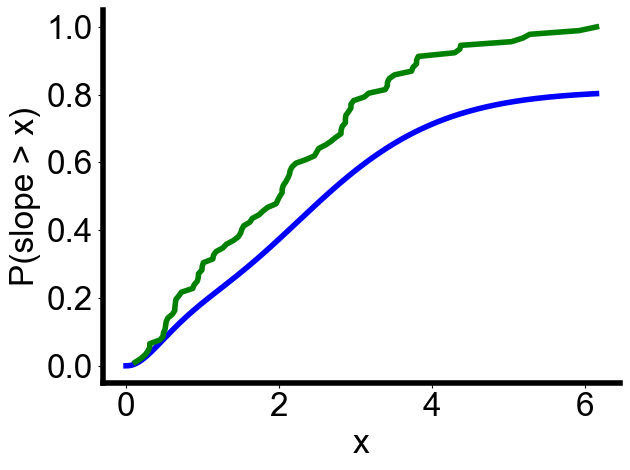

In [30]:
"""cumulative distribution of bimodal gamma fit"""
sorted_slopes = np.array(sorted(all_slopes[all_slopes >= 0]))
cum_dist = np.zeros_like(sorted_slopes)
for i in range(len(cum_dist)):
    cum_dist[i] = np.sum(sorted_slopes <= sorted_slopes[i]) / len(sorted_slopes)

plot_slopes = np.linspace(0, np.max(sorted_slopes), 1000)
bgamma_cum_dist = bgamma_cumulative(plot_slopes, alpha, beta, delta)

plt.figure()
plt.plot(plot_slopes, bgamma_cum_dist, 'b-', linewidth=4)
plt.plot(sorted_slopes, cum_dist, 'g-', linewidth=4)
plt.xlabel('x', fontsize=fontsize)
plt.ylabel('P(slope > x)', fontsize=fontsize)
ax = style_axes(plt.gca())

In [39]:
"""fit exp 2 to gamma"""
all_slopes =  np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 10
bins = np.linspace(0, np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
a = mean_slope_1 ** 2 / var_slope_1
b = mean_slope_1 / var_slope_1

plot_bins = np.linspace(0, 5, 1000)


bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, gamma_dist(plot_bins, a, b), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
plt.ylim([0, 2.5])
ax = style_axes(plt.gca())


/tmp/ipykernel_811058/440662364.py:23: RuntimeWarning: divide by zero encountered in power
  return beta ** alpha * (x ** (alpha - 1)) * np.exp(-beta * x) / gamma(alpha)


In [57]:
"""fit exp 2 to gamma"""
all_slopes =  np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 10
bins = np.logspace(-2, np.log10(5), n_bins)
counts, _ = np.histogram(all_slopes[all_slopes > 0], bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
a = mean_slope_1 ** 2 / var_slope_1
b = mean_slope_1 / var_slope_1

#plot_bins = np.linspace(0, 5, 1000)
plot_bins = np.logspace(-2, np.log10(5), 1000)


bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, gamma_dist(plot_bins, a, b), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
plt.ylim([1e-3, 50])
plt.xscale('log')
plt.yscale('log')
ax = style_axes(plt.gca())


In [82]:
"""fit exp 2 to gaussian"""
#all_slopes = np.array(slope_list_anterior + slope_list_posterior)# + slope_list_exp2_anterior + slope_list_exp2_posterior)
all_slopes =  np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 15
bins = np.logspace(-2, np.log10(5), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
mu = np.mean(all_slopes[all_slopes < 1])
sig = np.std(all_slopes[all_slopes < 1])
plot_bins = np.linspace(0, 5, 1000)


bins = bins[:-1]

fit = (1 / np.sqrt(2 * np.pi) / sig) * np.exp(-(plot_bins - mu) ** 2 / 2 / sig / sig)

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, fit, 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
plt.ylim([1e-3, 50])
plt.xscale('log')
plt.yscale('log')
ax = style_axes(plt.gca())


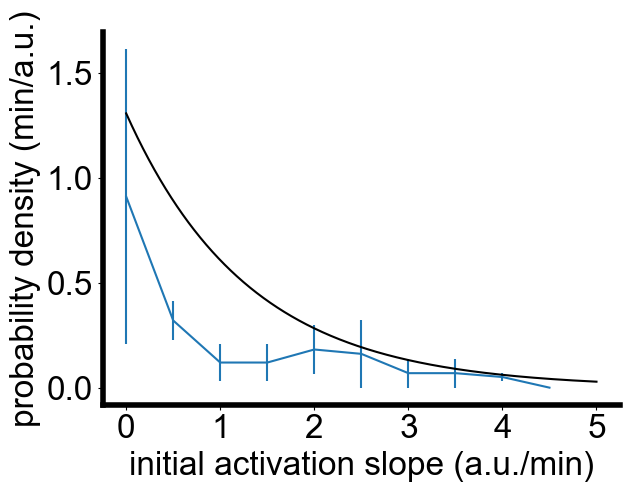

In [8]:
markersize = 18
markeredgewidth = 2
plt.figure()
n_bins = 10 + 1
bins = np.linspace(0, 5, n_bins)
prob_dens_arr = np.zeros((2, n_bins - 1))

"""exp 1"""
all_slopes = np.array(slope_list_anterior + slope_list_posterior)# + slope_list_exp2_anterior + slope_list_exp2_posterior)
#all_slopes = np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
all_slopes = all_slopes[all_slopes > 0]
#n_bins = 10
#bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
#bins = np.linspace(0, 3.2, n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
prob_dens_arr[0] = prob_dens
mean_slope_1 = np.mean(all_slopes)

#bins = bins[:-1]

# p0 = (1.25, 0.5, 0.5)

# res = minimize(negative_bgamma_llikelihood, p0, args=all_slopes, bounds=((0, np.inf), (0, np.inf), (0, np.inf)))
# alpha, beta, delta = res.x
# plot_bins = np.linspace(np.min(bins), np.max(bins), 1000)

# #plt.plot(plot_bins, bgamma(plot_bins, alpha, beta, delta), 'k-', linewidth=4)
# plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')




"""exp 2"""
#all_slopes = np.array(slope_list_anterior + slope_list_posterior + slope_list_exp2_anterior + slope_list_exp2_posterior)
all_slopes = np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
all_slopes = all_slopes[all_slopes > 0]
#n_bins = 10
#bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
#bins = np.linspace(0, 3.2, n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
prob_dens_arr[1] = prob_dens
mean_slope_2 = np.mean(all_slopes)

#bins = bins[:-1]

# p0 = (1.25, 0.5, 0.5)

# res = minimize(negative_bgamma_llikelihood, p0, args=all_slopes, bounds=((0, np.inf), (0, np.inf), (0, np.inf)))
# alpha, beta, delta = res.x
# plot_bins = np.linspace(np.min(bins), np.max(bins), 1000)

# #plt.plot(plot_bins, bgamma(plot_bins, alpha, beta, delta), 'k-', linewidth=4)
# plt.plot(bins, prob_dens, 'kd', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')

mean_prob_dens = np.mean(prob_dens_arr, axis=0)
std_prob_dens = np.std(prob_dens_arr, axis=0)

plt.errorbar(bins[:-1], mean_prob_dens, std_prob_dens)

mean_slope = (mean_slope_1 + mean_slope_2) / 2
plot_bins = np.linspace(0, 5, 1000)
exp_dist = mean_slope * np.exp(-plot_bins / mean_slope)
plt.plot(plot_bins, exp_dist, 'k-')


plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())


In [296]:
mean_slope

1.3059596964374132

In [288]:
std_prob_dens

array([0.70300334, 0.09399333, 0.08731924, 0.08731924, 0.11716722,
       0.16091954, 0.06896552, 0.06896552, 0.01835373, 0.        ])

/tmp/ipykernel_3965709/3134467923.py:23: RuntimeWarning: divide by zero encountered in power
  return (x ** (alpha - 1)) * np.exp(-beta * x) / gamma(alpha)
/tmp/ipykernel_3965709/4183666112.py:4: RuntimeWarning: divide by zero encountered in power
  plt.plot(x, x ** -0.5)


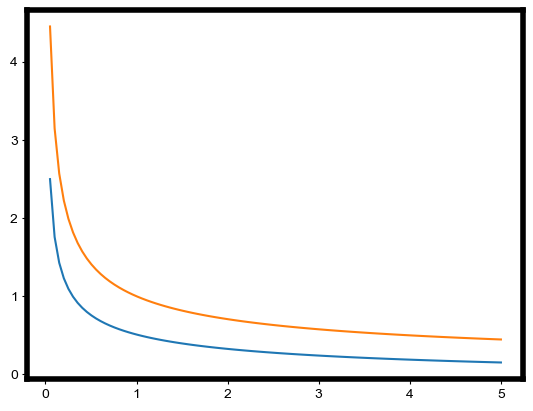

In [54]:
plt.figure()
x = np.linspace(0, 5, 100)
plt.plot(x, gamma_dist(x, 0.5, 0.1))
plt.plot(x, x ** -0.5)

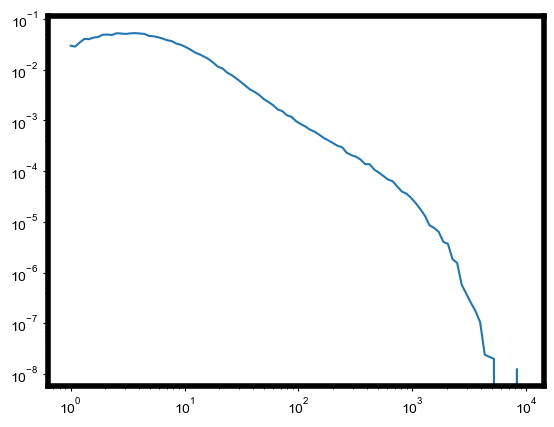

In [60]:
X0 = np.exp(np.random.normal(loc=2, scale=1, size=100_000))
#R = np.random.exponential(scale=900, size=100_000)
R = np.random.gamma(scale=0.5 * 24 * 60, shape=0.1, size=100_000)

Xt = X0 + R #* 24 * 60

bins = np.logspace(0, 4, 100)
counts, _ = np.histogram(Xt, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.figure()
plt.plot(bins[:-1], prob_dens)
plt.xscale('log')
plt.yscale('log')

In [113]:
"""testing mle for lognormal-gamma convolution model"""
def likelihood(x, mu, sigma, k, theta, n_samples=100_000):
    X0 = np.exp(np.random.normal(loc=mu, scale=sigma, size=n_samples))
    R = np.random.gamma(shape=k, scale=theta, size=n_samples)
    Xt = X0 + R

    bins = np.logspace(0, 7, int(n_samples / 1000))
    counts, _ = np.histogram(Xt, bins)
    # use a pseudo count of 1 to make the log likelihood well behaved
    counts[counts == 0 ] = 1
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    bins = bins[:-1]
    
    lh = np.zeros(len(np.array(x)))
    for i in range(len(lh)):
        index = np.where(np.abs(x[i] - bins) == np.min(np.abs(x[i] - bins)))[0][0]
        lh[i] = prob_dens[index]
        
    return lh
    

def neg_log_likelihood(p, args):
    k, theta = p
    x, mu, sigma, n_samples = args
    lh = likelihood(x, mu, sigma, k, theta, n_samples=n_samples)
    nllh = -1 * np.sum(np.log(lh))
    
    return nllh
    

In [116]:
"""simulate some data"""
mu = 6.25
sigma = 0.15
k = 0.1
theta = 0.5 * 24 * 60
n_samples = 100_000

X0 = np.exp(np.random.normal(loc=mu, scale=sigma, size=100))
R = np.random.gamma(scale=theta, shape=k, size=100)

Xt = X0 + R
args = [Xt, mu, sigma, n_samples]
p0 = (0.8, 300)


res = minimize(neg_log_likelihood, p0, args=args, bounds=((0, np.inf), (0, np.inf)), method='Nelder-Mead')
k_fit, theta_fit = res.x




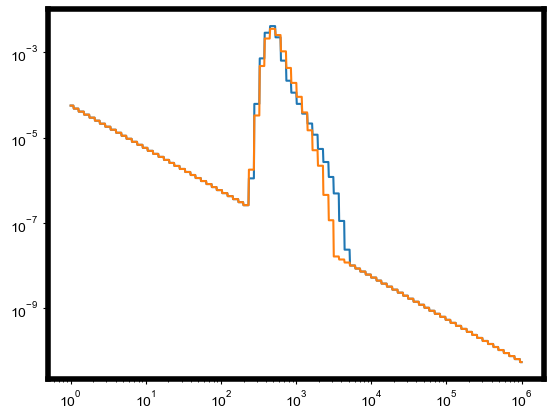

In [117]:
x = np.logspace(0, 6, 1000)
px = likelihood(x, mu, sigma, k, theta, n_samples)
px_fit = likelihood(x, mu, sigma, k_fit, theta_fit, n_samples)

plt.figure()
plt.plot(x, px)
plt.plot(x, px_fit)
plt.xscale('log')
plt.yscale('log')

In [107]:
theta_fit

349.4293396691137

In [108]:
k_fit

0.11393954018480197

In [81]:
res

      fun: 533.8025961471827
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.50556195e+08, -1.49233631e+08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([2.e-01, 7.e+02])

## resample time series rate distributions so that the number of nuclei along AP matches that from nuclear segmentation


In [5]:
def bin_aps(df, bins, ap_col='y'):
    _counts, bins = np.histogram(df.get(ap_col), bins)
    bins = bins[1:]
    partial_func = partial(get_ap_bin, bins=bins)
    binned_aps = df.get(ap_col).apply(partial_func)
    df[f'binned_{ap_col}'] = binned_aps.values
    
    return df
    

def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin
    

In [98]:
true_bins = np.array([0.02731848, 0.12458663, 0.22185478, 0.31912293, 0.41639109,
       0.51365924, 0.61092739, 0.70819554, 0.8054637 , 0.90273185,
       1.        ])

true_fracs = np.array([0.09863946, 0.04846939, 0.07227891, 0.125     , 0.14115646,
       0.13520408, 0.12414966, 0.11989796, 0.10204082, 0.03316327])





In [100]:
counts, _ = np.histogram(ys, true_bins)
counts

array([ 6, 24,  2,  3, 29, 40, 31, 14, 10,  0])

In [102]:
true_fracs * n_cells

array([16.57142928,  8.14285752, 12.14285688, 21.        , 23.71428528,
       22.71428544, 20.85714288, 20.14285728, 17.14285776,  5.57142936])

In [106]:
counts, _ = np.histogram(np.array(sampled_ys) / y_max, true_bins)
counts / np.sum(counts) * n_cells

array([10.14765101, 19.16778523, 14.65771812,  4.51006711, 29.31543624,
       28.18791946, 28.18791946, 14.65771812, 19.16778523,  0.        ])

In [109]:
sorted(df.binned_ap.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [117]:
plt.figure()
plt.hist(df[df.t==0].ap)

(array([10., 20.,  2.,  3., 16., 34., 30., 24., 10., 10.]),
 array([0.08538841, 0.16486362, 0.24433884, 0.32381405, 0.40328926,
        0.48276447, 0.56223969, 0.6417149 , 0.72119011, 0.80066532,
        0.88014054]),
 <BarContainer object of 10 artists>)

In [118]:
"""experiment 1"""
# experiment 1
y_max = 2998
df['ap'] = df['y'] / y_max
df = bin_aps(df, true_bins, ap_col='ap')
ys = df[df.t == 0].y
ys = ys / y_max

counts, _ = np.histogram(ys, true_bins)
fracs = counts / np.sum(counts)
sampled_rates = []
sampled_ys = []
n_cells = len(df.particle.unique())
t_fit_max = 40
t_fit_min = 10
minutes_per_time_point = 2

for i in range(len(true_bins) - 1):
    sub_df = df[df.binned_ap == i]
    counter = 0
    if len(sub_df) == 0:
        continue
    while counter < true_fracs[i] * n_cells - 1:
        particle = np.random.choice(sub_df.particle.unique())
        sub_sub_df = sub_df[sub_df.particle == particle]
        sub_sub_df = sub_sub_df.sort_values(by='t')
        if any(sub_sub_df.groupby(by='t').size().values > 1):
            continue
        t = sub_sub_df.t
        dpt = sub_sub_df.mean_dpt

        dpt = dpt[t <= t_fit_max]
        t = t[t <= t_fit_max]

        dpt = dpt[t > t_fit_min]
        t = t[t > t_fit_min]

        if len(t) > 4:
            slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
            sampled_rates.append(slope)
            sampled_ys.append(sub_sub_df.y.mean())
            counter += 1
            print(f'{i}, {counter}, {true_fracs[i]*n_cells}')

plt.figure()
counts, _ = np.histogram(np.array(sampled_ys) / y_max, true_bins)
plt.plot(true_bins[:-1], counts / np.sum(counts), 'k-', linewidth=4)
plt.plot(true_bins[:-1], true_fracs, 'b-', linewidth=4)
counts, _ = np.histogram(df[df.t==0].y / y_max)
plt.plot(true_bins[:-1], counts / np.sum(counts), 'g-', linewidth=4)   

"""fit exp 1 to gamma"""
all_slopes = sampled_rates
n_bins = 20
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
a = mean_slope_1 ** 2 / var_slope_1
b = mean_slope_1 / var_slope_1

plot_bins = np.linspace(0, np.max(all_slopes), 1000)
 

bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
plt.plot(bins, prob_dens, linewidth=4, color=colors['e.coli'])

#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, gamma_dist(plot_bins, a, b), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())


0, 1, 16.57142928
0, 2, 16.57142928
0, 3, 16.57142928
0, 4, 16.57142928
0, 5, 16.57142928
0, 6, 16.57142928
0, 7, 16.57142928
0, 8, 16.57142928
0, 9, 16.57142928
0, 10, 16.57142928
0, 11, 16.57142928
0, 12, 16.57142928
0, 13, 16.57142928
0, 14, 16.57142928
0, 15, 16.57142928
0, 16, 16.57142928
1, 1, 8.14285752
1, 2, 8.14285752
1, 3, 8.14285752
1, 4, 8.14285752
1, 5, 8.14285752
1, 6, 8.14285752
1, 7, 8.14285752
1, 8, 8.14285752
2, 1, 12.14285688
2, 2, 12.14285688
2, 3, 12.14285688
2, 4, 12.14285688
2, 5, 12.14285688
2, 6, 12.14285688
2, 7, 12.14285688
2, 8, 12.14285688
2, 9, 12.14285688
2, 10, 12.14285688
2, 11, 12.14285688
2, 12, 12.14285688
3, 1, 21.0
3, 2, 21.0
3, 3, 21.0
3, 4, 21.0
3, 5, 21.0
3, 6, 21.0
3, 7, 21.0
3, 8, 21.0
3, 9, 21.0
3, 10, 21.0
3, 11, 21.0
3, 12, 21.0
3, 13, 21.0
3, 14, 21.0
3, 15, 21.0
3, 16, 21.0
3, 17, 21.0
3, 18, 21.0
3, 19, 21.0
3, 20, 21.0
4, 1, 23.714285280000002
4, 2, 23.714285280000002
4, 3, 23.714285280000002
4, 4, 23.714285280000002
4, 5, 23.7142852800

In [35]:
counts

array([ 0,  6, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

In [67]:
df_exp2['ap'] = df_exp2['y'] / df_exp2['y'].max()
df_exp2 = bin_aps(df_exp2, true_bins, ap_col='ap')
ys = df_exp2[df_exp2.t == 0].y
ys = ys / 2998

counts, _ = np.histogram(ys, true_bins)
fracs = counts / np.sum(counts)

In [68]:
true_bins

array([0.02731848, 0.12458663, 0.22185478, 0.31912293, 0.41639109,
       0.51365924, 0.61092739, 0.70819554, 0.8054637 , 0.90273185,
       1.        ])

In [69]:
counts

array([ 0,  6,  0,  3, 17,  3,  0,  0,  0,  0])

In [73]:
df_exp2.y.max()

1685.436635678189

In [82]:
n_cells

36

In [84]:
true_fracs * n_cells

array([3.55102056, 1.74489804, 2.60204076, 4.5       , 5.08163256,
       4.86734688, 4.46938776, 4.31632656, 3.67346952, 1.19387772])

In [86]:
df_exp2.binned_ap.unique()

array([3, 4, 1, 0])

In [81]:
# experiment 2
y_max = 2998.0
df_exp2['ap'] = df_exp2['y'] / y_max
df_exp2 = bin_aps(df_exp2, true_bins, ap_col='ap')
ys = df_exp2[df_exp2.t == 0].y
ys = ys / y_max

counts, _ = np.histogram(ys, true_bins)
fracs = counts / np.sum(counts)


"""experiment 2"""
sampled_rates = []
sampled_ys = []
n_cells = len(df_exp2[df_exp2.t < t_fit_max].particle.unique())
t_fit_max = 12
t_fit_min = 0
minutes_per_time_point = 5

for i in range(len(true_bins) - 1):
    sub_df = df_exp2[df_exp2.binned_ap == i]
    counter = 0
    if len(sub_df[sub_df.t == 0]) == 0:
        continue
    while counter < true_fracs[i] * n_cells:
        particle = np.random.choice(sub_df[sub_df.t < t_fit_max].particle.unique())
        sub_sub_df = sub_df[sub_df.particle == particle]
        sub_sub_df = sub_sub_df.sort_values(by='t')
        if any(sub_sub_df.groupby(by='t').size().values > 1):
            continue
        t = sub_sub_df.t
        dpt = sub_sub_df.mean_dpt

        dpt = dpt[t <= t_fit_max]
        t = t[t <= t_fit_max]

        dpt = dpt[t > t_fit_min]
        t = t[t > t_fit_min]

        if len(t) > 4:
            slope, intercept, r, p, se = linregress(minutes_per_time_point * t, dpt)
            sampled_rates.append(slope)
            sampled_ys.append(sub_sub_df.y.mean())
            counter += 1

# check distribution of aps
plt.figure()
counts, _ = np.histogram(np.array(sampled_ys) / y_max, true_bins)
plt.plot(true_bins[:-1], counts / np.sum(counts), 'k-', linewidth=4)
plt.plot(true_bins[:-1], true_fracs, 'b-', linewidth=4)
counts, _ = np.histogram(df[df.t==0].y / y_max, true_bins)
plt.plot(true_bins[:-1], counts / np.sum(counts), 'g-', linewidth=4)

"""fit exp 2 to gamma"""
all_slopes = sampled_rates
n_bins = 10
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
var_slope_1 = np.var(all_slopes)
a = mean_slope_1 ** 2 / var_slope_1
b = mean_slope_1 / var_slope_1

plot_bins = np.linspace(0, np.max(all_slopes), 1000)
 

bins = bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
plt.plot(bins, prob_dens, linewidth=4, color=colors['e.coli'])

#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, gamma_dist(plot_bins, a, b), 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())


## experimenting with gaussian mixture models

In [119]:
from sklearn.mixture import GaussianMixture

In [120]:
gm = GaussianMixture(n_components=2, covariance_type='spherical')

In [126]:
x = np.array(slope_list_anterior + slope_list_posterior).reshape(-1, 1)
gm = gm.fit(x)

In [137]:

all_slopes = np.array(slope_list_anterior + slope_list_posterior)# + slope_list_exp2_anterior + slope_list_exp2_posterior)
n_bins = 12
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
plot_bins = np.linspace(0, 5, 100)
samps = gm.sample(1_000_000)[0].flatten()
counts, _ = np.histogram(samps, plot_bins)
plot_prob_dens = counts / np.sum(counts) / np.diff(plot_bins)

bins = bins[:-1]
plot_bins = plot_bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, plot_prob_dens, 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())

In [145]:
gm.covariances_

array([1.39045014, 0.15197448])

In [172]:
def ln_n_mix_density(mu0, sig0, means, covariances, weights, t, n_samples, n_bins):
    if len(means.shape) == 1:
        means = means.reshape(-1, 1)
    X0 = np.exp(np.random.normal(loc=mu0, scale=sig0, size=n_samples))
    gauss_mixture = GaussianMixture(n_components=2, covariance_type='spherical')
    gauss_mixture.means_ = means
    gauss_mixture.covariances_ = covariances
    gauss_mixture.weights_ = weights
    X1 = gauss_mixture.sample(n_samples)[0].flatten()
        
    X = X0 + X1 * t
    
    bins = np.logspace(0, np.log10(np.exp(mu0 + 3*sig0) + t * (np.max(means) + 3 * np.max(covariances))), n_bins)
    counts, _ = np.histogram(X, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    
    bins = bins[:-1]
    
    return prob_dens, bins

In [171]:
prob_dens

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [203]:
mu0 = 6.5
sig0 = 0.5
# means = np.array([2.73, 0.865])
# weights = np.array([0.60130736, 0.39869264])
# covariances = np.array([1.39045014, 0.15197448])

means = np.array([0.19206368, 1.84635246])
f_high = 0.09267028
weights = np.array([f_high, 1 - f_high])
covariances = np.array([0.03019308, 2.3331748 ])

t = np.linspace(0, 1440, 5)
n_samples = 1_000_000
n_bins = 100

reds = np.linspace(1, 0, len(t))
greens = np.linspace(0, 1, len(t))
blues = np.ones(len(t))

plt.figure()
for i in range(len(t)):
    prob_dens, bins = ln_n_mix_density(mu0, sig0, means, covariances, weights, t[i], n_samples, n_bins)
    plt.plot(bins, prob_dens, '-', linewidth=4, color=[reds[i], greens[i], blues[i]])

plt.xlim([1e2, 6.5e4])
plt.ylim([1e-7, 1e-2])
plt.xscale('log')
plt.yscale('log')

In [167]:
bins

array([1.        , 1.0197039 , 1.03979605, 1.06028409, 1.08117583,
       1.10247921, 1.12420235, 1.14635353, 1.16894117, 1.19197387,
       1.21546041, 1.23940972, 1.26383093, 1.28873333, 1.31412641,
       1.34001983, 1.36642345, 1.39334732, 1.4208017 , 1.44879704,
       1.477344  , 1.50645344, 1.53613645, 1.56640434, 1.59726862,
       1.62874104, 1.6608336 , 1.6935585 , 1.72692821, 1.76095544,
       1.79565314, 1.83103451, 1.86711304, 1.90390245, 1.94141676,
       1.97967025, 2.01867748, 2.0584533 , 2.09901287, 2.14037161,
       2.18254529, 2.22554995, 2.26940197, 2.31411805, 2.3597152 ,
       2.4062108 , 2.45362255, 2.50196849, 2.55126703, 2.60153695,
       2.65279738, 2.70506785, 2.75836824, 2.81271886, 2.8681404 ,
       2.92465396, 2.98228106, 3.04104364, 3.10096406, 3.16206516,
       3.22437018, 3.28790286, 3.35268738, 3.41874841, 3.4861111 ,
       3.55480109, 3.62484455, 3.69626813, 3.76909904, 3.843365  ,
       3.91909429, 3.99631575, 4.07505877, 4.15535333, 4.23723

Traceback (most recent call last):
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/figure.py", line 2264, in <lambda>
    'button_press_event', lambda event: self.canvas.pick(event))
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1762, in pick
    self.figure.pick(mouseevent)
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/artist.py", line 541, in pick
    a.pick(mouseevent)
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/artist.py", line 541, in pick
    a.pick(mouseevent)
  File "/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/matplotlib/artist.py", line 530, in pick
    for a in self.get_children():
  File "/home/brandon/anaconda3/envs/ome_zarr/l

In [198]:
"""experiment 2"""
gm = GaussianMixture(n_components=2, covariance_type='spherical')
all_slopes =  np.array(slope_list_exp2_anterior + slope_list_exp2_posterior)
all_slopes[all_slopes < 0] = 0
x = np.array(all_slopes).reshape(-1, 1)
gm = gm.fit(x)

n_bins = 12
bins = np.linspace(np.min(all_slopes), np.max(all_slopes), n_bins)
counts, _ = np.histogram(all_slopes, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
mean_slope_1 = np.mean(all_slopes)
plot_bins = np.linspace(0, 5, 100)
samps = gm.sample(1_000_000)[0].flatten()
counts, _ = np.histogram(samps, plot_bins)
plot_prob_dens = counts / np.sum(counts) / np.diff(plot_bins)

bins = bins[:-1]
plot_bins = plot_bins[:-1]

plt.figure()
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'],  markersize=markersize, markeredgewidth=markeredgewidth, markeredgecolor='k')
#plt.plot(plot_bins, exp_dist, 'k-')
plt.plot(plot_bins, plot_prob_dens, 'b-', linewidth=4)

plt.xlabel('initial activation slope (a.u./min)', fontsize=fontsize)
plt.ylabel('probability density (min/a.u.)', fontsize=fontsize)
ax = style_axes(plt.gca())
plt.yscale('log')

In [199]:
gm.weights_

array([0.90732972, 0.09267028])

In [200]:
gm.means_

array([[0.19206368],
       [1.84635246]])

In [201]:
gm.covariances_

array([0.03019308, 2.3331748 ])